In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
! pip install tensorflow-text
import tensorflow_text

import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.3 MB/s eta 0:00:00


### **After Down sampling the "big safe emails" to 3k safe email to be balanced with phishing**

In [ ]:

df_ph = pd.read_csv('body_and_class.csv')
df_safe = pd.read_csv('safe_downsampled.csv')

df_ph = df_ph.drop('Unnamed: 0', axis=1, errors='ignore')
df_ph= df_ph.drop_duplicates()

df_safe = df_safe.drop('Unnamed: 0', axis=1, errors='ignore')
df_safe = df_safe.drop_duplicates()

print(df_ph, df_safe)

df_balanced = pd.concat([df_safe,df_ph])


print(df_balanced.shape)
df_balanced = df_balanced.sample(frac=1, random_state=42)

df_balanced.groupby('class').describe()

print("Safe",len(df_safe))
print("Phishing",len(df_ph))

                                                   body     class
0     eBay Suspension\neBay Suspension\nNeed Help?\n...  phishing
1     Dear LaSalle Member,\nAs part of our continuin...  phishing
2       But I don't Pokemon in 1878 in 1874 Shall we...  phishing
3     Dear eBay member,\nDear eBay user,\nDuring our...  phishing
4     Dear valued customer\nNeed Help?\nWe regret to...  phishing
...                                                 ...       ...
3182  Dear NAFCU member,\nAs part of our security me...  phishing
3183  lay flog, me zing sell, net sick burr macepay ...  phishing
3184  eBay\nBilling \n          confirmation center\...  phishing
3185  Dear Valued Customer\nWe are committed to prot...  phishing
3186  National Credit Union Administration  Notifica...  phishing

[3187 rows x 2 columns]                                                    body       class
0     use Perl Daily Headline MailerDynDNS.org Offer...  Safe Email
1     conference on catalan studies ( linguisti

In [ ]:
df_ph = df_balanced[df_balanced['class'] == 'phishing']
df_safe = df_balanced[df_balanced['class'] == 'Safe Email']
from sklearn.utils import resample
df_ph_downsampled = resample(df_ph, replace=False, n_samples=300, random_state=42)
df_safe_downsampled = resample(df_safe, replace=False, n_samples=3000, random_state=42)

df_downsampled = pd.concat([df_ph_downsampled, df_safe_downsampled])

df_downsampled = df_downsampled.sample(frac=1, random_state=42)
print(len(df_downsampled))


3300


### **10% Phishing 90% Safe emails:**

### Map:  Phishing => 1 . Safe => 0




In [ ]:

df_downsampled['phishing']=df_downsampled['class'].apply(lambda x: 1 if x =='phishing' else 0)
df_downsampled.sample(5)



,body,class,phishing
460,syntax textbooks i need to order a textbook fo...,Safe Email,0
482,URL: http://boingboing.net/#85485775\nDate: No...,Safe Email,0
1201,re : thank you sevil . we are looking forward ...,Safe Email,0
1072,"hpl nom for april 7 , 2001 ( see attached file...",Safe Email,0
1996,chomsky ' 92 article i was about to send the f...,Safe Email,0


### **Split it into training and test data set**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['body'],df_downsampled['phishing'],
                                                    stratify=df_downsampled['phishing'],random_state=42,test_size=0.3)

X_train.head(4)

2641    Lacking in a  _____\n\t     / ___ \\n\t    / /...
148     On Thu, 2002-08-15 at 10:53, Erik Williamson w...
3062    Another thing I see in debian but not in my RH...
1185    [Tim]\n> One effect of getting rid of MINCOUNT...
Name: body, dtype: object


### **Using BERT model and get embeding vectors**


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text= bert_preprocess(text_input)
outputs= bert_encoder(preprocessed_text)

dropout_layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout_layer)


model = tf.keras.Model(inputs=[text_input], outputs = [dense_layer])
print( model.summary() )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
len(X_train)

2310

In [ ]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)



# **Model Train**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

X_train_preprocessed = np.array([str(sentence) for sentence in X_train])
X_test_preprocessed = np.array([str(sentence) for sentence in X_test])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class_weights = {0: 1, 1: 10}  # 0 corresponds to the majority class, and 1 corresponds to the minority class
history = model.fit(X_train_preprocessed, y_train, epochs=10, validation_split=0.2, class_weight=class_weights, callbacks=[early_stopping, checkpoint])

Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 1.2115 - accuracy: 0.5774 - precision: 0.1292 - recall: 0.6407

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 729s 12s/step - loss: 1.2115 - accuracy: 0.5774 - precision: 0.1292 - recall: 0.6407 - val_loss: 0.4079 - val_accuracy: 0.9177 - val_precision: 1.0000 - val_recall: 0.1163
Epoch 2/10
58/58 [==============================] - 697s 12s/step - loss: 1.0672 - accuracy: 0.7159 - precision: 0.1987 - recall: 0.7066 - val_loss: 0.6612 - val_accuracy: 0.5844 - val_precision: 0.1718 - val_recall: 0.9070
Epoch 3/10
58/58 [==============================] - 696s 12s/step - loss: 1.0066 - accuracy: 0.7592 - precision: 0.2317 - recall: 0.7186 - val_loss: 0.4939 - val_accuracy: 0.8377 - val_precision: 0.3400 - val_recall: 0.7907
Epoch 4/10
58/58 [==============================] - 700s 12s/step - loss: 0.9361 - accuracy: 0.7933 - precision: 0.2727 - recall: 0.7725 - val_loss: 0.3782 - val_accuracy: 0.9459 - val_precision: 0.6957 - val_recall: 0.7442
Epoch 5/10
58/58 [==============================] - 710s 12s/step - loss: 0.8586 - accuracy: 0.8366 - precision: 0.

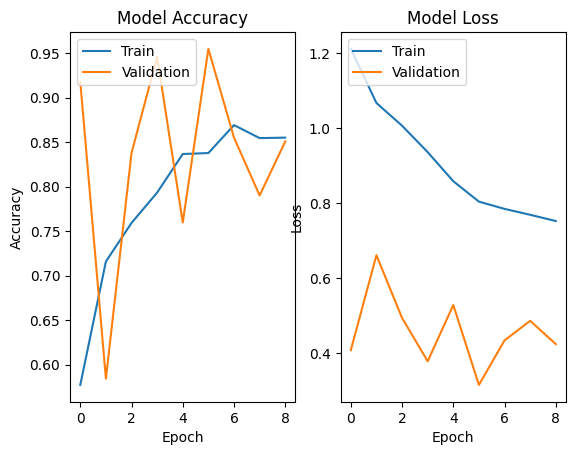

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


31/31 [==============================] - 298s 10s/step


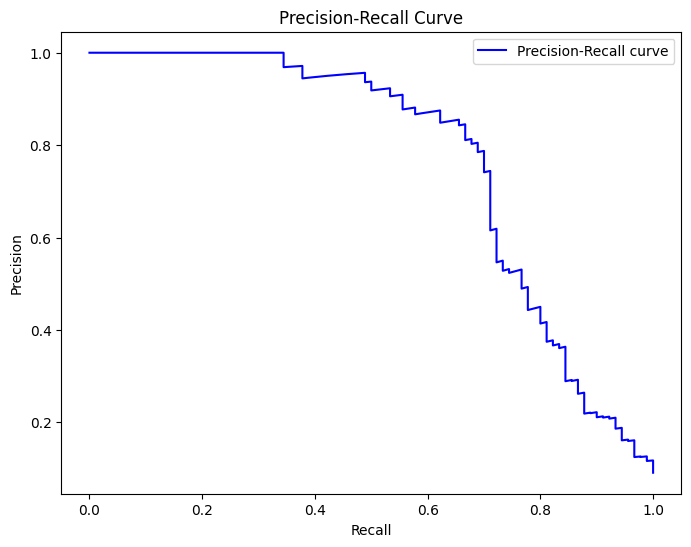

In [ ]:
results = model.evaluate(X_test_preprocessed, y_test)

y_pred = model.predict(X_test_preprocessed).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr}')

AUC-PR: 0.7685547769181951


In [ ]:
accuracy = results[model.metrics_names.index('accuracy')]
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.9545454382896423
Precision: 0.7848101258277893
Recall: 0.6888889074325562


In [ ]:
new_model = tf.keras.models.load_model('best_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

tokenizer = tf.keras.preprocessing.text.Tokenizer()
new_text = [
    "- LaSalle Bank Update Report In attention of all LaSalle Bank customers,As the Internet and information technology enable us to expand our services, we are committed to maintaining the trust customers have placed in us for protecting the privacy and security of information we have about you. In order to protect your information against unauthorized access, identity theft and account fraud we earnestly ask you to update your profile.To get started, please click the link below:https:N54/L58/onlinebanking.lasallebank.com/login-init.jspIf you received this notice and you are not the authorized account holder,please be aware that it is in violation of our policy to represent oneselfas another LaSalle Bank user. Such action may also be in violation of local, national, and/or international law. LaSalle Bank is committed to assist law enforcement with any inquiries related to attempts to misappropriate personal information withthe intent to commit fraud or theft. Information will be provided at the requestof law enforcement agencies to ensure that perpetrators are prosecuted to the fullest extent of the law.Thanks for your patience as we work together to protect your account.Regards,LaSalle Bank Customer Support Center.This site is directed at or made available to persons in the United States and LaSalle Bank customers only. Products and services described, as well as associated fees, charges, interest rates, and balance requirements may differ among geographic locations. Not all products and services are offered at all J51 2005 -LaSalle Bank Corporation. All rights reserverd. LaSalle Bank N.A. Member FDIC. Equal Housing Lender. Equal Opportunity Lender."
]

tokenizer.fit_on_texts(new_text)
sequences = tokenizer.texts_to_sequences(new_text)

padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=128)

predictions = new_model.predict(padded_sequences)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file7d9qedn2.py", line 74, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(self)._has_training_argument), if_body_3, else_body_3, get_state_3, set_state_3, ('result', 'training'), 1)
    File "/tmp/__autograph_generated_file7d9qedn2.py", line 72, in else_body_3
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)
    File "/tmp/__autograph_generated_file7d9qedn2.py", line 72, in <lambda>
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)

    ValueError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).
    
    in user code:
    
        File "/usr/local/lib/python3.10/dist-packages/tensorflow_hub/keras_layer.py", line 250, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (3 total):
            * <tf.Tensor 'inputs:0' shape=(None, 128) dtype=string>
            * False
            * None
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * False
            * None
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * True
            * None
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * False
            * None
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * True
            * None
          Keyword arguments: {}
    
    
    Call arguments received by layer 'keras_layer' (type KerasLayer):
      • inputs=tf.Tensor(shape=(None, 128), dtype=string)
      • training=False
